In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('D:/IS403_O21_HTCL_15/Dataset/MSFT.csv')
df1 = df.reset_index()['Close']

# Chọn cột 'Close' và cột 'Date'
df = df[['Date', 'Close']]

# Chuyển đổi cột 'Date' thành định dạng datetime
df['Date'] = pd.to_datetime(df['Date'])

# Thiết lập cột 'Date' làm chỉ mục
df.set_index('Date', inplace=True)

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[0:train_size]
test_data = df1[train_size:len(df1)]

time_step = 100
#Lấy thêm time_window ngày từ tập train vào tập test để dự đoán ngày đầu tiên của tập test
test_data = np.concatenate((train_data[-time_step:], test_data))

In [3]:
# 5. Hàm Create Dataset
import numpy

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [4]:
from keras.optimizers import Adam

# Define LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))  # Adjusting input_shape according to window size
model.add(LSTM(50))  # Second LSTM layer without return_sequences to reduce complexity
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)


c:\Users\GIAHUY\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 111s 698ms/step - loss: 0.0503 - val_loss: 0.0013
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - loss: 7.7226e-04 - val_loss: 0.0014
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - loss: 6.4324e-04 - val_loss: 0.0020
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 6.2267e-04 - val_loss: 0.0013
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - loss: 6.2449e-04 - val_loss: 0.0017
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - loss: 6.4371e-04 - val_loss: 0.0016
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - loss: 6.1418e-04 - val_loss: 7.3245e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - loss: 6.7542e-04 - val_loss: 0.0013
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 6.4333e-04 - val_loss: 6.5385e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - loss: 6.8680e-04 - val_loss: 5.7040e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 5.4708e-

In [5]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
x_input = x_input.reshape((1, time_step, 1))

temp_input = x_input[0].tolist()
temp_input = temp_input[0]
days_to_predict = 90
lst_output = []
n_steps = 100
i = 0
while(i < days_to_predict):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

test_data = test_data[time_step:]
lst_output.insert(0, test_data[-1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [6]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_pred = scaler.inverse_transform(y_pred)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Đánh giá MAE
mae = mean_absolute_error(test_data, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Đánh giá MSE
mse = mean_squared_error(test_data, y_pred)
print("Mean Squared Error (MSE):", mse)

# Đánh giá RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Đánh giá MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 4.697497401317737
Mean Squared Error (MSE): 32.48687070761348
Root Mean Squared Error (RMSE): 5.699725494057891
Mean Absolute Percentage Error (MAPE): 1.1931078732426221


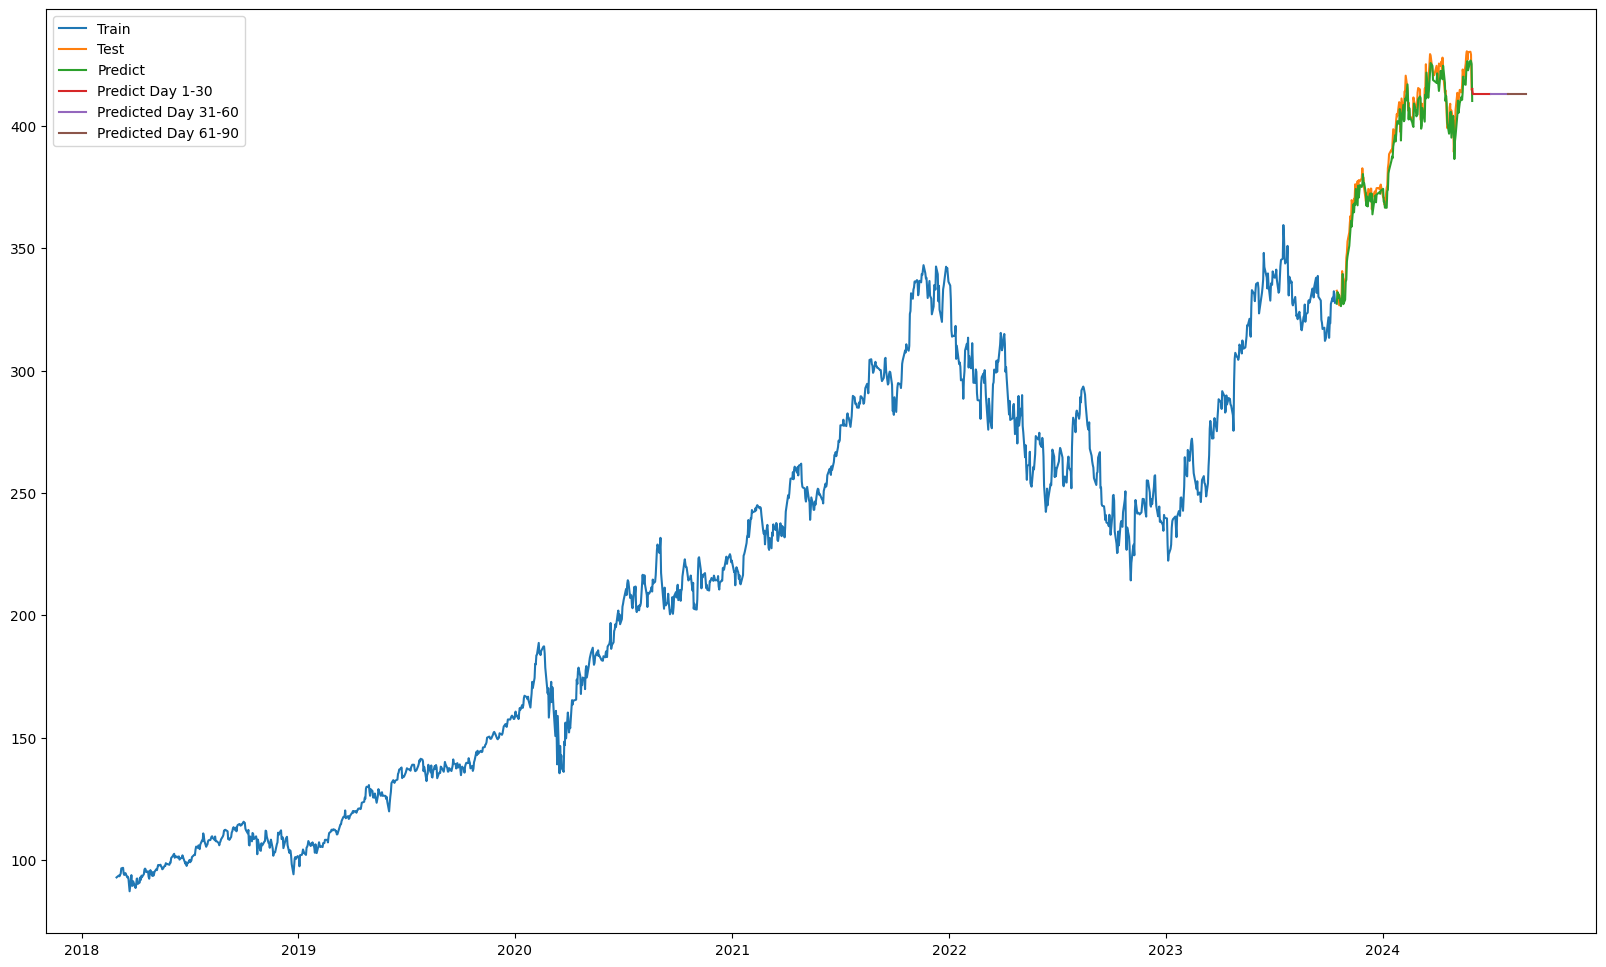

158
158
1416


In [8]:
# 14. Vẽ hình
plt.figure(figsize=(20, 12))

# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
train_data_index = df[0:train_size].index
plt.plot(train_data_index, train_data)

test_data_index = df[train_size:len(df)].index
plt.plot(test_data_index, test_data)

plt.plot(test_data_index, y_pred)



next_30days_index = pd.date_range(start=df.index[-2] + pd.Timedelta(days=1), periods=31)
next_60days_index = pd.date_range(next_30days_index[-1] + pd.Timedelta(days=1), periods=30)
next_90days_index = pd.date_range(next_60days_index[-1] + pd.Timedelta(days=1), periods=30)

plt.plot(next_30days_index, scaler.inverse_transform(lst_output)[:31])

plt.plot(next_60days_index, scaler.inverse_transform(lst_output)[31:61])

plt.plot(next_90days_index, scaler.inverse_transform(lst_output)[61:])

plt.legend(['Train', 'Test', 'Predict', 'Predict Day 1-30', 'Predicted Day 31-60', 'Predicted Day 61-90'])
plt.show()
print(len(test_data))
print(len(y_pred))

print(len(train_data))